# Détection de trajectoires anormales pour la surveillance maritime

La détection d'anomalies, est une problématique importante en apprentissage automatique et analyse de données. Le concept d'anomalie fait référence à des observations ou des comportements atypiques par rapport à la norme, souvent susceptibles d'indiquer des situations inattendues ou des incidents potentiellement préjudiciables. Pendant les 2 prochaines séances, nous explorerons diverses approches de détection d'anomalies, que nous illustrerons sur des données de trajectoires de navires.

<center>
<img src="https://drive.google.com/uc?id=1m7Tar-_SAsEM05wvhK5Nf72Q11h-etpL">
</center>

Ces trajectoires, représentent des déplacements de navires à travers une séquences de 16 coordonnées $(x, y)$, et peuvent révéler des schémas de comportement normaux, mais également des situations anormales telles que des déviations de routes ou des activités inattendues en mer.

Nous approcherons de problème de deux manières différentes : la détection d'anomalies supervisée dans un premier temps (TP 1), et la détection d'anomalies non-supervisée pour le TP 2.

Le premier TP consistera en un rappel des notions vues en Analyse de Données au 1er semestre, et à l'introduction de l'environnement de travail pour les séances de TP de ce semestre, à savoir Python à travers les librairies *NumPy*, *Scikit-learn* (et plus tard, *Keras* et *Tensorflow*). Nous commencerons par projeter les données dans un espace à plus faible dimension à l'aide de l'Analyse en Composante Principales, puis nous testerons deux algorithmes d'apprentissage supervisé, à savoir les Support Vector Machines (SVM) et les forêts aléatoires. Ces méthodes s'appuient sur des **ensembles d'entraînement étiquetés** pour apprendre à discriminer les trajectoires normales des anomalies.

Dans le second volet, nous nous tournerons vers des approches de détection d'anomalies non-supervisées. Nous examinerons l'utilisation de LOF (Local Outlier Factor), un algorithme basé sur la densité locale, ainsi que One-Class SVM, une méthode qui apprend à définir la région normale de l'espace des données sans nécessiter d'exemples d'anomalies.


## Chargement des données

Commençons par récupérer les données au format texte sur l'URL suivante :

In [1]:
!wget http://acarlier.fr/donnees.txt

--2024-05-26 08:15:57--  http://acarlier.fr/donnees.txt
Resolving acarlier.fr (acarlier.fr)... 212.194.248.69, 2a02:842a:5e:4701:b48a:fe3:257b:3972
Connecting to acarlier.fr (acarlier.fr)|212.194.248.69|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://acarlier.fr/donnees.txt [following]
--2024-05-26 08:15:57--  https://acarlier.fr/donnees.txt
Connecting to acarlier.fr (acarlier.fr)|212.194.248.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133640 (131K) [text/plain]
Saving to: ‘donnees.txt’

donnees.txt         100%[===================>] 130.51K   553KB/s    in 0.2s    

2024-05-26 08:15:58 (553 KB/s) - ‘donnees.txt’ saved [133640/133640]



Ce fichier contient les données au format texte : chaque ligne correspond à une trajectoire de navire.

Une trajectoire est définie par une séquence de 16 paires de coordonnées $(x_i, y_i)$, $i=1..16$.

Chaque trajectoire constitue une ligne du fichier texte, organisée comme suit : $x_1, x_2, ..., x_{16}, y_1, y_2, ..., y_{16}$

Les 250 premières trajectoires correspondent à des trajectoires normales, et les 10 dernières sont des anomalies.

In [2]:
import numpy as np

# Lecture de la base de données et mise en forme des données
def read_dataset(file_path):
    data = np.loadtxt(file_path) # Lecture des données dans un numpy array de dimension (260, 32)

    # Nombre de trajectoires de la base de données
    num_trajectories = data.shape[0]

    # Séparation des trajectoires normales et anormales (anomalies)
    X_normal = data[:num_trajectories-10]
    X_anomaly = data[num_trajectories-10:]


    return X_normal, X_anomaly

X_normal, X_anomaly = read_dataset('donnees.txt')
X = np.concatenate([X_normal, X_anomaly])
Y = np.concatenate([np.ones(X_normal.shape[0]), np.zeros(X_anomaly.shape[0])])
X.shape, Y.shape

((260, 32), (260,))

La fonction suivante permet d'afficher les trajectoires :

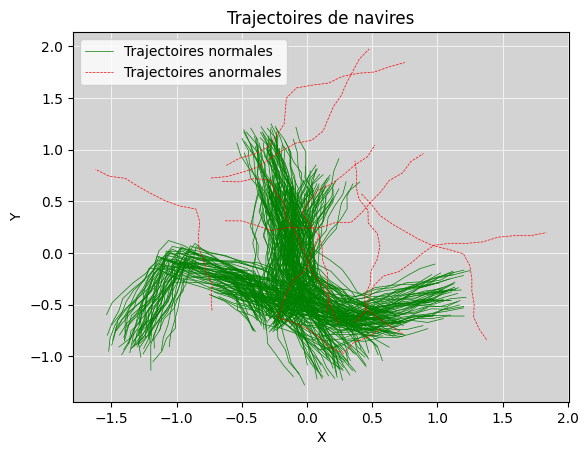

In [3]:
import matplotlib.pyplot as plt

def plot_trajectories(normal_trajectories, anomaly_trajectories):
    # Affichage des trajectoires normales en vert
    plt.plot([], [], color='green', linewidth=0.5, label='Trajectoires normales')
    for traj in normal_trajectories:
        # Les 16 premières coordonnées sont les abscisses des points de la trajectoire
        x = traj[:16]
        # Les 16 coordonnées suivantes sont les ordonnées des points de la trajectoire
        y = traj[16:]
        plt.plot(x, y, color='green', linewidth=0.5)


    # Affichage des trajectoires anormales en rouge et pointillés
    plt.plot([], [], color='red', linestyle='dashed', linewidth=0.5, label='Trajectoires anormales')
    for traj in anomaly_trajectories:
        x = traj[:16]
        y = traj[16:]
        plt.plot(x, y, color='red', linestyle='dashed', linewidth=0.5)

    # Labels d'axes et titre
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Trajectoires de navires')

    # Couleur de fond et grille
    plt.gca().set_facecolor('lightgrey')
    plt.grid(color='white', linestyle='-', linewidth=0.5)

    # Ajout de la légende
    plt.legend()

    # Affichage de la figure
    plt.show()


plot_trajectories(X_normal, X_anomaly)

## TP 2 - Détection d'anomalies non supervisée

Dans ce second TP, nous allons maintenant considérer que nous ne disposons pas d'ensemble d'apprentissage labellisé, ce qui signifie que nous nous ne savons pas au préalable si certaines des données sont des anomalies ou pas.

Commencez par exécutez les blocs ci-dessous, pour reprendre les résultats du TP précédent.

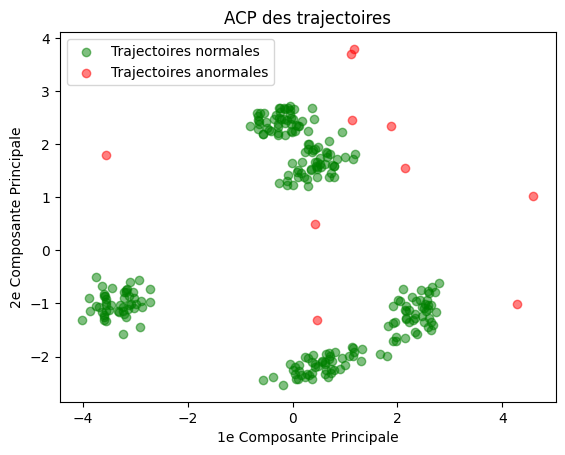

In [4]:
def plot_decision_boundary(X, y, model, title):
    h = .02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlGn, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlGn, edgecolors='k', marker='o')
    plt.title(title)
    plt.xlabel('1e Composante Principale')
    plt.ylabel('2e Composante Principale')

    plt.show()

# Fonction de projection des données sur les num_axis premiers axes de l'ACP
def compute_pca(data, num_axis=2):
    # Etape 1: Centrage des données
    mean_values = np.mean(data, axis=0)
    centered_data = data - mean_values

    # Etape 2: Calcul de la matrice de variance-covariance
    covariance_matrix = np.cov(centered_data, rowvar=False)

    # Etape 3: Calcul des couples propres de la matrice de variance-covariance
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Etape 4: Réorganisation des vecteurs propres selon l'ordre des valeurs propres décroissantes
    sorted_indices = np.flip(np.argsort(eigenvalues))
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Etape 5: Récupération des num_axis premiers vecteurs propres
    top_eigenvectors = sorted_eigenvectors[:, :num_axis]

    # Etape 6: Projection des données sur les axes de l'ACP
    projected_data = np.matmul(centered_data, top_eigenvectors)

    return projected_data

# Projection des trajectoires normales et anormales dans les plan des 2 premiers axes de l'ACP
X_pca = compute_pca(X, num_axis=2)

# Affichage des trajectoires dans le plan des 2 premiers axes de l'ACP
plt.scatter(X_pca[:250, 0], X_pca[:250, 1], color='green', label='Trajectoires normales', alpha=0.5)
plt.scatter(X_pca[250:, 0], X_pca[250:, 1], color='red', label='Trajectoires anormales', alpha=0.5)

# Labels d'axes et titre
plt.xlabel('1e Composante Principale')
plt.ylabel('2e Composante Principale')
plt.title('ACP des trajectoires')

# Légende
plt.legend()

# Affichage de la figure
plt.show()

Le code ci-dessous nous permettra d'évaluer les résultats et d'afficher la matrice de confusion obtenue.

**Travail à faire**:
Complétez le code ci-dessous pour calculer le nombre de vrais positifs (TP), vrais négatifs (TN), faux positifs (FP) et faux négatifs (FN), ainsi que le pourcentage de bonnes classifications.

In [5]:
def evaluate(y_pred, y):
  # Calcul des prédictions du modèle sur l'ensemble de test
  TP = np.count_nonzero(np.logical_and(y_pred == 1, y == 1))
  TN = np.count_nonzero(np.logical_and(y_pred == 0, Y == 0))
  FP = np.count_nonzero(np.logical_and(y_pred == 0, y == 1))
  FN = np.count_nonzero(np.logical_and(y_pred == 1, y == 0))

  accuracy = (TP + TN)/(TP+TN+FP+FN)

  print(f"Pourcentage de bonnes classifications : {100*accuracy:.2f}%")
  print("Matrice de confusion :")
  print("------------------------")
  print("| pred/true |  0  |  1  |")
  print("------------------------")
  print(f"|     0     | {TN:3d} | {FN:3d} |")
  print("------------------------")
  print(f"|     1     | {FP:3d} | {TP:3d} |")
  print("------------------------")

### 1 - DBSCAN

Dans un premier temps, nous allons expérimenter un algorithme vu en cours au 1er semestre : l'algorithme DBSCAN (**D**ensity **B**ased **S**patial **C**lustering of **A**pplications with **N**oise). Il s'agit pour mémoire d'un algorithme de clustering, c'est-à-dire de regroupement des données en clusters de données ressemblantes. Toutes les données qui ne sont pas affectées à un cluster peuvent être considérées comme des anomalies.

L'algorithme DBSCAN repose sur la définition d'un voisinage autour de chaque donnée, dans un rayon $\epsilon$. Les données dont le $\epsilon$-voisinage contient trop peu d'autres données sont considérées comme des anomalies.

Le code ci-dessous vous permettra d'exécuter DBSCAN puis d'afficher les points. Les labels renvoyés par l'algorithme sont positifs ou nuls : tous les points labellisés 0 appartiennent à un premier cluster, tous les points labellisés 1 à un 2e cluster, etc. Les points labellisés -1 sont des anomalies (ou des points *Noise* dans la terminologie DBSCAN).

**Travail à faire**:
-   Complétez le code ci-dessous pour exécuter DBSCAN et afficher les anomalies détectées.
-   Prenez ensuite le temps de chercher une valeur du paramètre $\epsilon$ qui permet d'obtenir les meilleurs résultats.

Pourcentage de bonnes classifications : 50.00%
Matrice de confusion :
------------------------
| pred/true |  0  |  1  |
------------------------
|     0     |   0 |   0 |
------------------------
|     1     |  48 |  48 |
------------------------


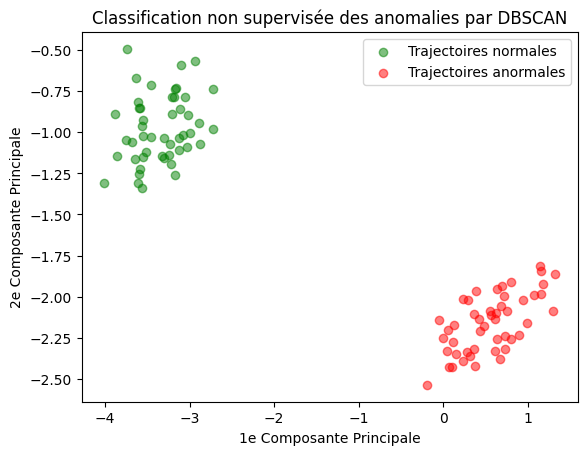

In [6]:
from sklearn.cluster import DBSCAN

# Appel de l'algorithme DBSCAN
clustering = DBSCAN(eps=0.3).fit(X_pca)
# Les prédictions sont contenues dans la variable clustering.labels_
# Les anomalies (classe 0) correspondent aux points pour lesquels DBSCAN assigne la valeur -1
y_pred = clustering.labels_

evaluate(y_pred,Y)

# Affichage des trajectoires dans le plan des 2 premiers axes de l'ACP
plt.scatter(X_pca[y_pred==1, 0], X_pca[y_pred==1, 1], color='green', label='Trajectoires normales', alpha=0.5)
plt.scatter(X_pca[y_pred==0, 0], X_pca[y_pred==0, 1], color='red', label='Trajectoires anormales', alpha=0.5)

# Labels d'axes et titre
plt.xlabel('1e Composante Principale')
plt.ylabel('2e Composante Principale')
plt.title('Classification non supervisée des anomalies par DBSCAN')

# Légende
plt.legend()

# Affichage de la figure
plt.show()

### 2 - Local Outlier Factor

L'algorithme DBSCAN, bien que pouvant donner de bons résultats pour la détection d'anomalies, n'est pas complètement adapté pour la détection d'anomalies. Il ne peut donner qu'une information binaire (oui ou non) sur la possibilité pour une donnée d'être une anomalie.

La méthode LOF (**L**ocal **O**utlier **F**actor) vue en cours, permet justement d'améliorer cet aspect. Elle consiste à calculer un score LOF$(x_i)$ associé à chaque donnée. Plus ce score est élevé, plus la donnée a de chance d'être une anomalie.

Pour chaque point $x_i$ on commence d'abord par calculer :     

$$\mu(x_i) = \left(\frac{1}{|\mathcal{N}_k(x_i)|}
\sum_{x_j\in \mathcal{N}_k(x_i)}
d_k(x_i,x_j)
\right)^{-1},\quad \text{où } \mathcal{N}_k(x_i) \text{ désigne les $k$ plus proches voisins de $x_i$} $$

Puis :    
$$\text{LOF}_k(x_i) =
\frac{\frac{1}{|\mathcal{N}_k(x_i)|}
\sum_{x_j\in \mathcal{N}_k(x_i)}\mu(x_j)}{\mu(x_i)} $$


On va procéder de la manière suivante

1.   Calculer une matrice des distances de tous les points à tous les points
2.   Trouver, pour chaque point, les indices de ses k plus proches voisins
3.   Calculer $\mu(x_i)$ pour tous point $x_i$
4.   Calculer LOF($x_i$) pour tout point $x_i$
5.   Diviser LOF($x_i$) par la valeur LOF maximale de la base de données pour obtenir des valeurs entre 0 et 1.

**Complétez le code ci-dessous pour implémenter LOF**


In [7]:
import numpy as np


def calculate_lof(X, k=5):

  # Calcul de la matrice des distances de tous les points à tous les points
  x = X[:,0]
  y = X[:,1]
  x1_matrice_distances = x[:,np.newaxis]
  x2_matrice_distances = x[np.newaxis,:]
  y1_matrice_distances = y[:,np.newaxis]
  y2_matrice_distances = y[np.newaxis,:]
  matrice_distances = np.sqrt((x1_matrice_distances-x2_matrice_distances)**2 + (y1_matrice_distances-y2_matrice_distances)**2)
  print(matrice_distances.shape) # vérifier la dimension

  # Détermination des indices des k plus proches de voisins de chaque point
  indices_kppv = np.argsort(matrice_distances, axis=1)
  indice_matrice_kppv = indices_kppv[:, 1:k+1]

  # Calcul de la "reachability distance" (mu) de chaque point
  mu = np.zeros(np.size(x))
  for i in range(np.size(x)):
    mu[i] = 1/((1/k)*(np.sum(matrice_distances[i,indice_matrice_kppv[i,:]])))

  # Calcul du LOF pour chaque point
  lof = np.zeros(np.size(x))
  for i in range(np.size(x)):
    lof[i]= (1/k*np.sum(mu[indice_matrice_kppv[i,:]]))/mu[i]

  # Normalisation du LOF entre 0 et 1
  lof_normalized = lof/np.max(lof)

  return lof_normalized

Le code ci-dessous permet d'appeler votre fonction LOF.

**Travail à faire**:
-   Vérifiez qu'avec $k=5$ vous obtenez le même résultat que celui qui vous est fourni.
-   Testez différentes valeurs de $k$. Pour quelle valeur obtient-on les meilleurs résultats ?

(260, 260)
Pourcentage de bonnes classifications : 97.69%
Matrice de confusion :
------------------------
| pred/true |  0  |  1  |
------------------------
|     0     |   7 |   3 |
------------------------
|     1     |   3 | 247 |
------------------------


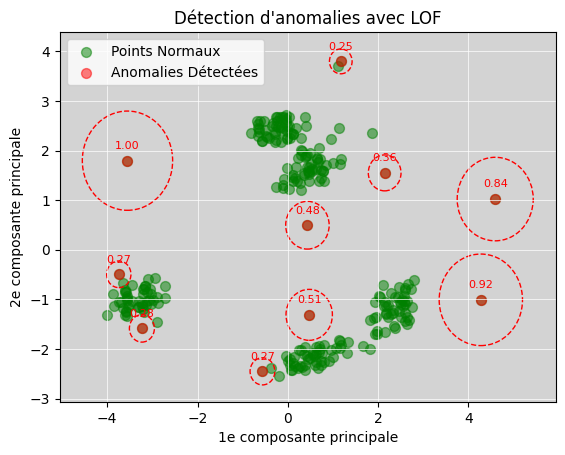

In [8]:
result_lof = calculate_lof(X_pca,k=5)

# Trouver les indices des 10 points avec les scores LOF les plus élevés
top_10_indices = np.argsort(result_lof)[-10:]
y_pred = np.ones(Y.shape)
y_pred[top_10_indices] = 0

evaluate(y_pred,Y)

# Affichage des points avec des cercles proportionnels au LOF normalisé
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='green', s=50, alpha=0.5, label='Points Normaux')

# Affichage des 10 points avec les scores LOF les plus élevés en noir avec des cercles
plt.scatter(X_pca[top_10_indices, 0], X_pca[top_10_indices, 1], c='red', s=50, alpha=0.5, label='Anomalies Détectées')

for i in top_10_indices:
    circle = plt.Circle((X_pca[i, 0], X_pca[i, 1]), result_lof[i], color='red', fill=False, linestyle='dashed')
    plt.gca().add_patch(circle)
    plt.text(X_pca[i, 0], X_pca[i, 1]+0.3, f"{result_lof[i]:.2f}", fontsize=8, color='red', ha='center', va='center')


# Configuration du graphique
plt.title('Détection d\'anomalies avec LOF')
plt.xlabel('1e composante principale')
plt.ylabel('2e composante principale')
plt.legend()

# Personnalisation de l'arrière-plan et de la grille
plt.gca().set_facecolor('lightgrey')
plt.grid(color='white', linestyle='-', linewidth=0.5)

# Affichage du graphique
plt.show()

Résultat attendu :     
```
Pourcentage de bonnes classifications : 97.69%
Matrice de confusion :
------------------------
| pred/true |  0  |  1  |
------------------------
|     0     |   7 |   3 |
------------------------
|     1     |   3 | 247 |
------------------------
```

<center>
<img src="https://drive.google.com/uc?id=1UfNGdoVnYaRHxqRQmrOBejZ_MmEc01HZ">
</center>

### 3 - One-Class SVM

Le One-Class SVM est une variante des SVM adaptée à la détection d'anomalies. Nous avons vu en cours qu'il nécessite de positionner deux hyperparamètres :    
-   $\gamma$ qui conditionne le noyau gaussien
-   $\nu$ qui est une borne supérieure du nombre de données considérées comme des anomalies.

Il est naturel de poser $\nu = \frac{10}{260}$. Pour $\gamma$, vous pouvez implémenter la formule d'Aggarwal : $\gamma = \frac{1}{2 \sigma^2}$ où $\sigma$ est la médiane des distances entre toutes les données.

**Travail à faire** :    
-   Implémentez le calcul de $\gamma$ par la formule d'Aggarwal et affichez le résultat obtenu.
-   Testez d'autres valeurs de $\gamma$ et cherchez celle qui convient le mieux au problème d'après vous.


In [ ]:
from sklearn.svm import OneClassSVM

# Calcul de gamma par la formule d'Aggarwal (reprise du code de la partie LOF)


# Entraînement d'un SVM avec noyau gaussien
oc_svm_model = ...

# Evaluation du modèle
y_pred = oc_svm_model.predict(X_pca)
y_pred = np.where(y_pred<0, 0, 1)
evaluate(y_pred,Y)

# Affichage de la frontière de décision
plot_decision_boundary(X_pca, Y, oc_svm_model, "One-Class SVM à marge souple et noyau gaussien")

### 4 - Isolation Forests

Dans cette partie qui vous est laissée libre, il vous revient de tester les forêts d'isolation. Cherchez comment exécutez cet algorithme dans scikit-learn et testez différentes valeurs d'hyperparamètrs pour identifier ceux qui vous donnent les meilleurs résultats.